# Connecting the google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing neccessary libraries

In [2]:
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import load_img
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Dropout, LSTM, Embedding, add, Input
from keras.models import Model

# Load preprocess images, captions, and tokenizer

In [4]:
# load caption
with open("/content/drive/MyDrive/Project/Image-Captioning Project/Preprocessing/captions_dict.pkl", "rb") as f:
  captions_dict = pickle.load(f)
with open("/content/drive/MyDrive/Project/Image-Captioning Project/Preprocessing/all_captions.pkl", "rb") as f:
  all_captions = pickle.load(f)

# load image features
with open("/content/drive/MyDrive/Project/Image-Captioning Project/Preprocessing/features.pkl", "rb") as f:
  img_features = pickle.load(f)

# load tokenizer
with open("/content/drive/MyDrive/Project/Image-Captioning Project/Preprocessing/tokenizer.pkl", "rb") as f:
  tokenizer = pickle.load(f)

In [5]:
captions_dict['1000268201_693b08cb0e'], all_captions[5:10]

(['<startseq> child in pink dress is climbing up set of stairs in an entry way <endseq>',
  '<startseq> girl going into wooden building <endseq>',
  '<startseq> little girl climbing into wooden playhouse <endseq>',
  '<startseq> little girl climbing the stairs to her playhouse <endseq>',
  '<startseq> little girl in pink dress going into wooden cabin <endseq>'],
 ['<startseq> black dog and spotted dog are fighting <endseq>',
  '<startseq> black dog and tri-colored dog playing with each other on the road <endseq>',
  '<startseq> black dog and white dog with brown spots are staring at each other in the street <endseq>',
  '<startseq> two dogs of different breeds looking at each other on the road <endseq>',
  '<startseq> two dogs on pavement moving toward each other <endseq>'])

In [6]:
img_features['1000268201_693b08cb0e']

array([[2.507475, 0.      , 0.      , ..., 0.      , 0.      , 0.      ]],
      dtype=float32)

In [7]:
tokenizer.word_index['dog']

8

# Vocab size and maxlen

In [8]:
vocab_size = len(tokenizer.word_index)+1
max_len = max(len(caption.split()) for caption in all_captions)

In [9]:
vocab_size, max_len

(8485, 35)

# Train Test Split

In [10]:
imageIds = list(captions_dict.keys())
split = int(len(imageIds) * 0.90)
train = imageIds[:split]
test = imageIds[split:]

In [11]:
len(train), len(test)

(7281, 810)

# Data Generator Function

we have ram less than 16 gb, so if we directly train our model it will crash as we have large number of dataset and vocabulary, so we will create a data genrator functon to avoid crashing

In [12]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                # print(X1.shape, X2.shape, y.shape)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [13]:
# how we are creating the pairs (X, y)
# let's take an example: '<startseq> girl going into wooden building <endseq>'

#  X1                         X2                                  y
# image        <startseq>                                        girl
# image        <startseq> girl                                   going
# image        <startseq> girl going                             into
# image        <startseq> girl going into                        wooden
# image        <startseq> girl going into wooden                 building
# image        <startseq> girl going into wooden building        <endseq>


# we are giving input and geting the ouput and for next iteration we are having input as input+output
# and having the ouput and doing unitill we reach at <endseq> token

# Model Building

In [33]:
def define_model(input_features, vocab_size, max_len):
  # ---- encoder model ------
  # image features layer
  inputs1 = Input(shape=(input_features,))
  fe1 = Dropout(0.4)(inputs1) # to avoid overfitting
  fe2 = Dense(256, activation='relu')(fe1)

  # sequence model (text process layer)
  inputs2 = Input(shape=(max_len,))
  se1 = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(inputs2)
  se2 = Dropout(0.4)(se1) # to avoid overfitting
  se3 = LSTM(256)(se2)

  # ------ decoder model ------
  decoder1 = add([fe2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)

  # tie it together [image, seq] [word]
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

  # plot the model
  plot_model(model, show_shapes=True)

  # Load and display the model image using matplotlib
  plt.figure(figsize=(15, 10))
  img = plt.imread('model.png')
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  return model

In [34]:
input_features = img_features['1000268201_693b08cb0e'].shape[1]
input_features

4096

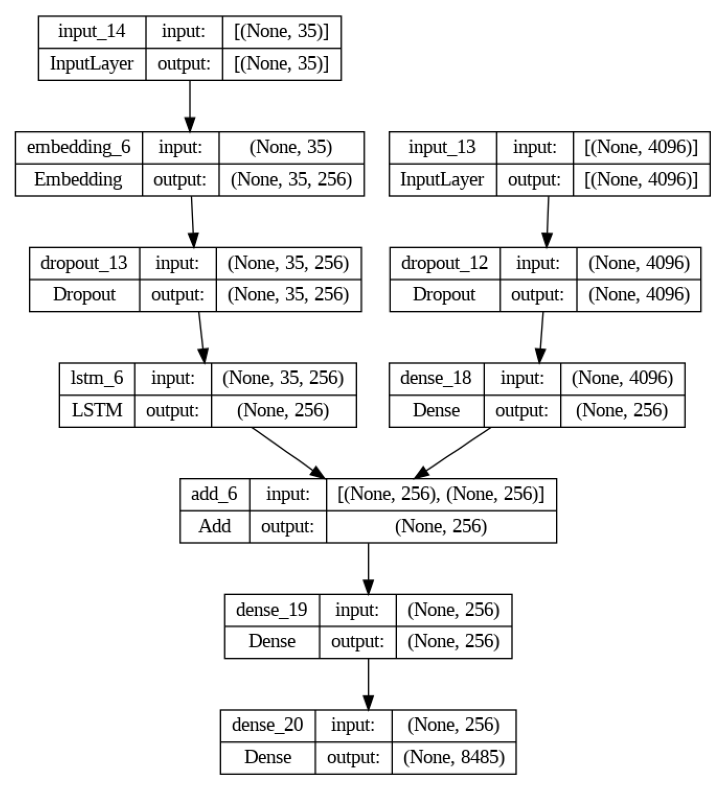

In [35]:
model = define_model(input_features, vocab_size, max_len)

In [36]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 35)]                 0         []                            
                                                                                                  
 input_13 (InputLayer)       [(None, 4096)]               0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 35, 256)              2172160   ['input_14[0][0]']            
                                                                                                  
 dropout_12 (Dropout)        (None, 4096)                 0         ['input_13[0][0]']            
                                                                                            

# Train model

In [ ]:
# train the model
epochs = 10
batch_size = 32
steps = len(train) // batch_size
history = []

for i in range(epochs):
    # create data generator
    generator = data_generator(train, captions_dict, img_features, tokenizer, max_len, vocab_size, batch_size)
    # fit for one epoch
    hist = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    history.append(hist)

# Save Model

In [46]:
model.save("/content/drive/MyDrive/Project/Image-Captioning Project/Model Building/model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
with open("/content/drive/MyDrive/Project/Image-Captioning Project/Model Building/history.pkl", "wb") as f:
  pickle.dump(history, f)